In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# %matplotlib inline  # For displaying plots in notebooks (if you're using Jupyter)


In [3]:
data = pd.read_csv('Hr.csv')  # Load CSV file
print(data.shape)             # Show (rows, columns)
print(data.columns)           # Show column names
print(data.head())            # Show first few rows
print(data.info())            # Show data types and missing values


(1200, 28)
Index(['EmpNumber', 'Age', 'Gender', 'EducationBackground', 'MaritalStatus',
       'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency',
       'DistanceFromHome', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction',
       'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel',
       'EmpJobSatisfaction', 'NumCompaniesWorked', 'OverTime',
       'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction',
       'TotalWorkExperienceInYears', 'TrainingTimesLastYear',
       'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany',
       'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition', 'PerformanceRating'],
      dtype='object')
  EmpNumber  Age Gender EducationBackground MaritalStatus    EmpDepartment  \
0  E1001000   32   Male           Marketing        Single            Sales   
1  E1001006   47   Male           Marketing        Single            Sales   
2  E1001007   40   Male       Life Sciences       Married            

EmpDepartment
Data Science              3.050000
Development               3.085873
Finance                   2.775510
Human Resources           2.925926
Research & Development    2.921283
Sales                     2.860590
Name: PerformanceRating, dtype: float64


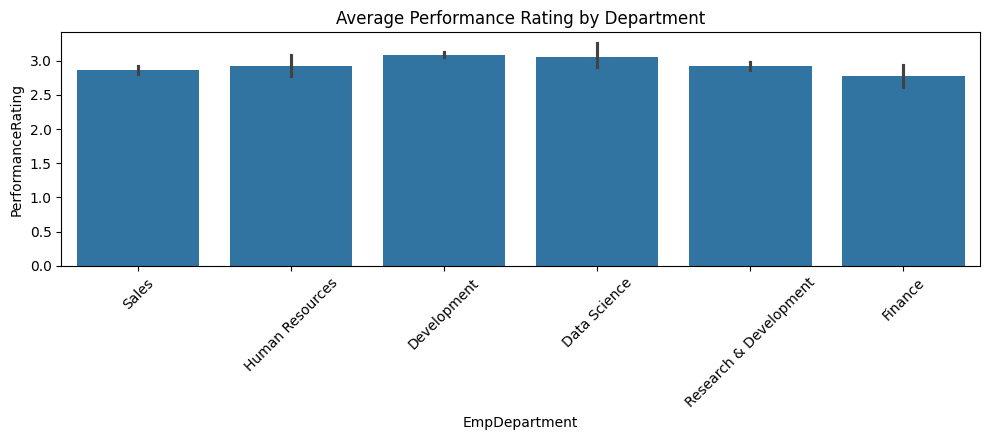

In [4]:
dept_per = data[['EmpDepartment', 'PerformanceRating']]  # Select only these 2 columns
print(dept_per.groupby('EmpDepartment')['PerformanceRating'].mean())  # Average by department

# Plot
plt.figure(figsize=(10, 4.5))
sns.barplot(x='EmpDepartment', y='PerformanceRating', data=dept_per)
plt.xticks(rotation=45)
plt.title("Average Performance Rating by Department")
plt.tight_layout()
plt.show()


EmpDepartment           PerformanceRating
Data Science            3                     17
                        4                      2
                        2                      1
Development             3                    304
                        4                     44
                        2                     13
Finance                 3                     30
                        2                     15
                        4                      4
Human Resources         3                     38
                        2                     10
                        4                      6
Research & Development  3                    234
                        2                     68
                        4                     41
Sales                   3                    251
                        2                     87
                        4                     35
Name: count, dtype: int64


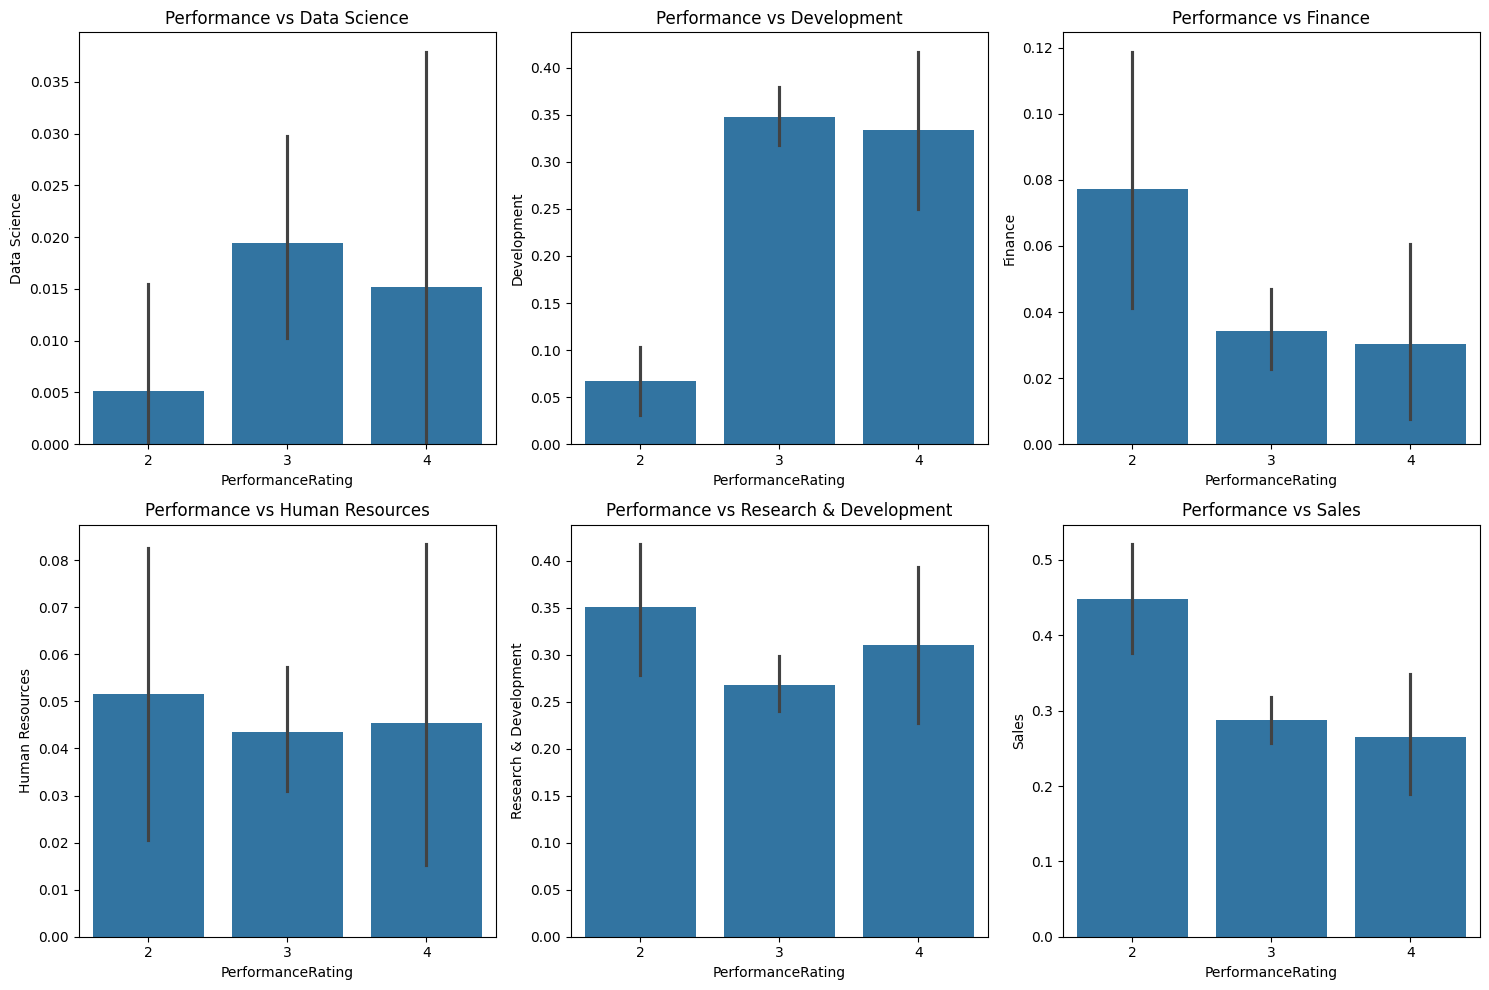

In [5]:
print(dept_per.groupby('EmpDepartment')['PerformanceRating'].value_counts())

# One-hot encoding for departments
dummies = pd.get_dummies(dept_per['EmpDepartment'])
dept_rating = pd.concat([dummies, dept_per['PerformanceRating']], axis=1)

# Bar plots for each department
plt.figure(figsize=(15, 10))
for i, col in enumerate(dummies.columns):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x='PerformanceRating', y=col, data=dept_rating)
    plt.title(f"Performance vs {col}")
plt.tight_layout()
plt.show()


In [6]:
# Encode specific categorical columns into numbers
for i in [2, 3, 4, 5, 6, 7, 16, 26]:
    data.iloc[:, i] = LabelEncoder().fit_transform(data.iloc[:, i])


In [7]:
# Remove Employee Number (not useful)
data.drop('EmpNumber', axis=1, inplace=True)

# Split data into input features (X) and target label (y)
X = data.drop('PerformanceRating', axis=1)
y = data['PerformanceRating']

# Convert everything to numeric and handle any missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)


In [8]:
# Split: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
params = {
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}

# Use GridSearchCV to find best parameters
model = GridSearchCV(RandomForestClassifier(n_estimators=23, random_state=33),
                     params, scoring='accuracy')
model.fit(X_train, y_train)

print("Best Parameters Found:", model.best_params_)


Best Parameters Found: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 4}


In [10]:
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           2       0.89      0.87      0.88        63
           3       0.94      0.96      0.95       264
           4       0.79      0.67      0.72        33

    accuracy                           0.92       360
   macro avg       0.87      0.83      0.85       360
weighted avg       0.91      0.92      0.92       360



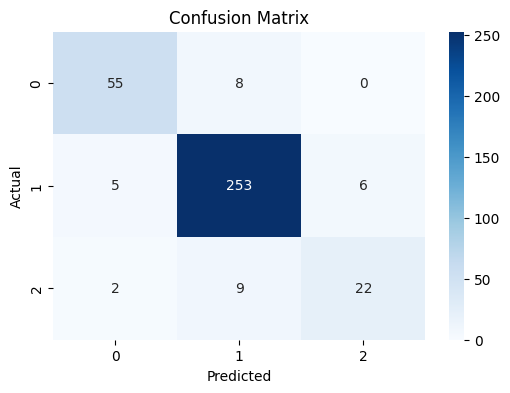

In [11]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


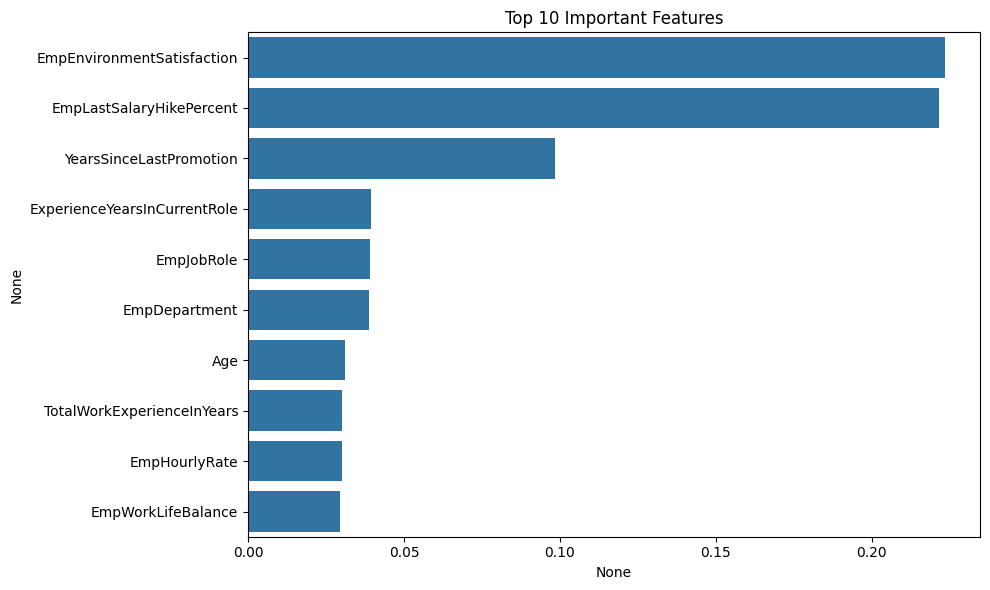

In [12]:
# Get feature importance from the best model
feat_imp = pd.Series(model.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()
